# Recommendations with IBM - Data Analysis

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

## Preparations

Import libraries and local scripts along with loading the cleaned data `articles` and `interactions`.

In [1]:
!pip install -e ../

Obtaining file:///C:/Users/netxph/Projects/ibm-recommend
  Attempting uninstall: ibm-recommend
    Found existing installation: ibm-recommend 0.1.0
    Uninstalling ibm-recommend-0.1.0:
      Successfully uninstalled ibm-recommend-0.1.0
  Running setup.py develop for ibm-recommend


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ibm_recommend.project_tests as t

from ibm_recommend.matrix import fit_transform, calculate_accuracy, intersect_data, plot_accuracy

%matplotlib inline

In [3]:
articles = pd.read_csv("../data/processed/articles.csv")
articles.article_id = articles.article_id.astype(str)
articles.head()

,article_id,name,description,body
0,0,Detect Malfunctioning IoT Sensors with Streami...,Detect bad readings in real time using Python ...,Skip navigation Sign in SearchLoading...\r\n\r...
1,1,Communicating data science: A guide to present...,"See the forest, see the trees. Here lies the c...",No Free Hunch Navigation * kaggle.com\r\n\r\n ...
2,2,"This Week in Data Science (April 18, 2017)",Here’s this week’s news in Data Science and Bi...,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
3,3,DataLayer Conference: Boost the performance of...,Learn how distributed DBs solve the problem of...,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA..."
4,4,Analyze NY Restaurant data using Spark in DSX,This video demonstrates the power of IBM DataS...,Skip navigation Sign in SearchLoading...\r\n\r...


In [4]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   article_id   1051 non-null   object
 1   name         1051 non-null   object
 2   description  1048 non-null   object
 3   body         1037 non-null   object
dtypes: object(4)
memory usage: 33.0+ KB


In [5]:
interactions = pd.read_csv("../data/processed/interactions.csv")
interactions.article_id = interactions.article_id.astype(str)
interactions.head()

,user_id,article_id,title,email
0,1,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,2,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,3,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,4,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,5,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [6]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     45993 non-null  int64 
 1   article_id  45993 non-null  object
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


## <a class="anchor" id="Exploratory-Data-Analysis">Part I: Exploratory Data Analysis</a>

### `1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [7]:
interactions.groupby("email").user_id.count().sort_values(ascending = False)

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
                                           ... 
1b520f0f65c0aee52d4235f92fb2de58fa966635      1
7a67e4a2902a20062e1f2a6835b6e099b34b4f6c      1
c4b7e639e91b1d18e5b9c000f0ad3354888fcdde      1
7a7fb282789944665ffc1cddee5ddbdbd7ca9f64      1
9655144418d25a0e074616840447e6e5dbef0069      1
Name: user_id, Length: 5148, dtype: int64

<AxesSubplot:>

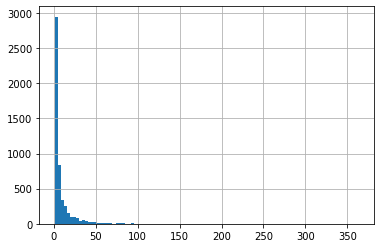

In [8]:
# non-unique interactions

interactions.groupby("email").user_id.count().hist(bins=100)

In [9]:
interactions[["email", "article_id"]].drop_duplicates().groupby("email").article_id.count().sort_values(ascending = False)

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    135
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    135
d9032ff68d0fd45dfd18c0c5f7324619bb55362c    101
c60bb0a50c324dad0bffd8809d121246baef372b    100
a37adec71b667b297ed2440a9ff7dad427c7ac85     97
                                           ... 
1ab433bafebd7f8b6322c05def9b41e0f029ea83      1
8283f83275dbd8cc8a2dd4d35a25f4a86310afbd      1
c1ad3e68598e288e5df72275ba03444ee218aab8      1
1ab7c183ceb155cab3b9dcc92f36039b025cd86e      1
262b5095f21d3addbff0ab212a968a467cc7592b      1
Name: article_id, Length: 5148, dtype: int64

<AxesSubplot:>

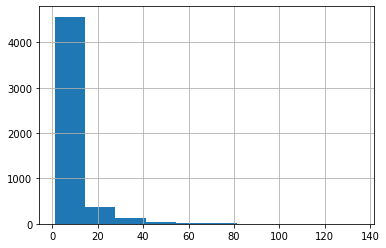

In [10]:
# unique interactions

interactions[["email", "article_id"]].drop_duplicates().groupby("email").article_id.count().hist(bins=10)

In [11]:
# Fill in the median and maximum number of user_article interactions below

median_val = interactions.groupby("email").count().median().values[0]
print(f"50% of individuals interact with {median_val} number of articles or fewer.")

max_views_by_user = interactions.groupby("email").count().max().values[0]
print(f"The maximum number of user-article interactions by any 1 user is {max_views_by_user}.")

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


### `2.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [12]:
unique_articles = interactions.article_id.nunique()
print(f"The number of unique articles that have at least one interaction: {unique_articles}")

total_articles = len(articles)
print(f"The number of unique articles on the IBM platform: {total_articles}")

unique_users = interactions.email.nunique()
print(f"The number of unique users: {unique_users}")

user_article_interactions = len(interactions)
print(f"The number of user-article interactions: {user_article_interactions}")

The number of unique articles that have at least one interaction: 714
The number of unique articles on the IBM platform: 1051
The number of unique users: 5148
The number of user-article interactions: 45993


### `3.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [13]:
most_viewed_article_id = str(interactions.groupby("article_id").count().email.sort_values(ascending = False).index[0])
print(f"The most viewed article in the dataset as a string with one value following the decimal: {most_viewed_article_id}")

max_views = interactions.groupby("article_id").count().email.sort_values(ascending = False).values[0]
print(f"The most viewed article in the dataset was viewed how many times? {max_views}")

The most viewed article in the dataset as a string with one value following the decimal: 1429
The most viewed article in the dataset was viewed how many times? 937


In [14]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


## <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

### `1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [15]:
def get_top_articles(data, n):
    '''
    INPUT:
    n - (int) the number of top articles to return
    data - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''

    article_interacts = data \
        .groupby(by=["article_id", "title"]) \
        .agg(interacts = ("title", "count")) \
        .reset_index() \
        .sort_values(by="interacts", ascending = False)

    top_articles = article_interacts.title.head(n).tolist()
    
    return top_articles

def get_top_article_ids(data, n):
    '''
    INPUT:
    n - (int) the number of top articles to return
    data - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    article_interacts = data \
        .groupby(by=["article_id", "title"]) \
        .agg(interacts = ("title", "count")) \
        .reset_index() \
        .sort_values(by="interacts", ascending = False)

    top_articles = article_interacts.article_id.head(n).tolist()
    
    return top_articles

In [16]:
print(get_top_articles(interactions, 10))
print(get_top_article_ids(interactions, 10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429', '1330', '1431', '1427', '1364', '1314', '1293', '1170', '1162', '1304']


In [17]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(interactions, 5)
top_10 = get_top_articles(interactions, 10)
top_20 = get_top_articles(interactions, 20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles, interactions)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


## <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


### `1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [18]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(data):
    '''
    INPUT:
    data - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''

    user_item = data[["user_id", "article_id"]].groupby(by=["user_id", "article_id"]).agg(lambda x: 1).unstack(fill_value = 0)
    
    return user_item

user_item = create_user_item_matrix(interactions)

In [19]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


### `2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [20]:
def compute_similarities(data, user1, user2):
    '''
    INPUT:
    user1 - (int) user id
    user2 - (int) user id
    data - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    similarity - (float) similarity score between user1 and user2
    
    Description:
    Compute the cosine similarity between two users based on the user-item matrix
    '''
    user1_articles = data.loc[user1][data.loc[user1] == 1].index.values
    user2_articles = data.loc[user2][data.loc[user2] == 1].index.values
    
    common_articles = np.intersect1d(user1_articles, user2_articles, assume_unique=True)

    # since it's just zeros and ones, we can just sum the common articles

    return len(common_articles)
    

In [21]:
def find_similar_users(data, user_id, rec_num = 5):
    '''
    INPUT:
    data - (pandas dataframe) matrix of users by articles: 
    user_id - (int) a user_id
                1's when a user has interacted with an article, 0 otherwise
    rec_num - (int) the number of recommendations you would like for the user
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''

    similar_users = pd.DataFrame(
        [[i, compute_similarities(data, user_id, i)] for i in data.index.values if i != user_id], 
        columns=["user_id", "similarity"]
    ) \
    .sort_values(by="similarity", ascending=False) \
    .head(rec_num) \
    .user_id.tolist()

    return similar_users 
        

In [22]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(user_item, 1, rec_num=10)))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(user_item, 3933)))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(user_item, 46, rec_num=3)))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


### `3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [23]:
def get_article_names(data, article_ids):
    '''
    INPUT:
    data - (pandas dataframe) df as defined at the top of the notebook
    article_ids - (list) a list of article ids
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''

    return data[data.article_id.isin(article_ids)].title.unique().tolist()


def get_user_articles(data, user_id):
    '''
    INPUT:
    data - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    user_id - (int) a user id
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    num_interactions = data[["user_id", "article_id", "title"]].groupby("article_id").agg(count = ("user_id", "count")).reset_index()

    user_articles = data[["user_id", "article_id", "title"]][data.user_id == user_id].drop_duplicates()

    sorted_articles = pd.merge(user_articles, num_interactions, on="article_id").sort_values(by="count", ascending=False)
    

    return sorted_articles.article_id.tolist(), sorted_articles.title.tolist() # return the ids and names


def user_user_recs(data, user_id, rec_num=10):
    '''
    INPUT:
    data - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise
    user_id - (int) a user id
    rec_num - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''

    recs = []    
    matrix = create_user_item_matrix(data)
    user_articles = get_user_articles(data, user_id)[0]
    similar_users = find_similar_users(matrix, user_id)

    for user in similar_users:
        articles = get_user_articles(data, user)[0]
        for article in articles:
            if article not in user_articles and article not in recs:
                recs.append(article)
                if len(recs) == rec_num:
                    return recs
    
    return recs # return even if rec_num is not met

In [24]:
# Check Results
get_article_names(interactions, user_user_recs(interactions, 1, 10)) # Return 10 recommendations for user 1

['healthcare python streaming application demo',
 'ml optimization using cognitive assistant',
 'the nurse assignment problem',
 'predicting churn with the spss random tree algorithm',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model',
 'insights from new york car accident reports',
 'model bike sharing data with spss',
 'analyze accident reports on amazon emr spark',
 'movie recommender system with spark machine learning']

In [25]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(interactions, ['1024', '1176', '1305', '1314', '1422', '1427'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(interactions, ['1320', '232', '844'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(interactions, 20)[0]) == set(['1320', '232', '844'])
assert set(get_user_articles(interactions, 20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(interactions, 2)[0]) == set(['1024', '1176', '1305', '1314', '1422', '1427'])
assert set(get_user_articles(interactions, 2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


### `4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [26]:
def get_top_sorted_users(data, user_id):
    '''
    INPUT:
    data - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    user_id - (int)
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    matrix = create_user_item_matrix(data)

    neighbors_df = pd.DataFrame(
        [[i, compute_similarities(matrix, user_id, i)] for i in matrix.index.values if i != user_id], 
        columns=["neighbor_id", "similarity"]
    ) \
    .sort_values(by="similarity", ascending=False) 

    
    neighbors_df["num_interactions"]  = neighbors_df.neighbor_id.apply(lambda x: len(data[data.user_id == x]))
    neighbors_df = neighbors_df.sort_values(by=["similarity", "num_interactions"], ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(data, user_id, rec_num=10):
    '''
    INPUT:
    data - (pandas dataframe) matrix of users by articles:
            1's when a user has interacted with an article, 0 otherwise
    user_id - (int) a user id
    rec_num - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''

    recs = []    
    user_articles = get_user_articles(data, user_id)[0]
    similar_users = get_top_sorted_users(data, user_id)

    for user in similar_users.neighbor_id:
        articles = get_user_articles(data, user)[0]

        for article in articles:
            if article not in user_articles and article not in recs:
                recs.append(article)
                if len(recs) == rec_num:
                    break
        
        if len(recs) == rec_num:
            break

    rec_names = get_article_names(data, recs)
    
    return recs, rec_names

In [27]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(interactions, 20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330', '1427', '1364', '1170', '1162', '1304', '1351', '1160', '1354', '1368']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


### `5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [28]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(interactions, 1).iloc[0].neighbor_id # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(interactions, 131).iloc[9].neighbor_id # Find the 10th most similar user to user 131

In [29]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


### `6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

> **Cold Start Problem**

> The above recommendation is no use when dealing with new users. The only way we can provide recommendations is by providing rank-based recommendations. If the user profile is also available, we can perhaps try to look for users that has profile similarities and retrieve the articles interacted.

> Rank-based recommendations may not be enough as it lacks the other recommendation factors such as novelty, serendipity and diversity.

### `7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [30]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(interactions, 10)

In [31]:
assert set(new_user_recs) == set(['1314','1429','1293','1427','1162','1364','1304','1170','1431','1330']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


## <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

### `1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [32]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

### `2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

### `3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [33]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



## <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

### `1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [34]:
# Load the matrix here
user_item_matrix = pd.read_pickle('../models/user_item_matrix.p')

In [35]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### `2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [36]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

> **The Case of Interactions**

> As rating is not provided in the data, we can only rely on interactions. Interactions data has only 2 definite data, `1 - interacted` and `0 - not interacted`. Since the table has no nulls, SVD can work as recommender in this type of table.

### `3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

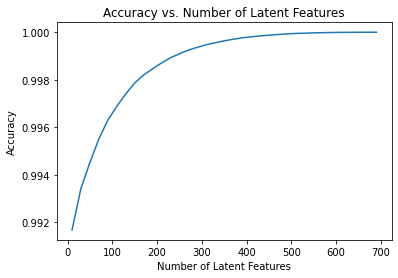

In [37]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)


plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(user_item_matrix.shape[0]*user_item_matrix.shape[1]));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

### `4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [38]:

interactions_train = interactions.head(40000)
interactions_test = interactions.tail(5993)

interactions_train.shape, interactions_test.shape

((40000, 4), (5993, 4))

In [39]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''

    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()

    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(interactions_train, interactions_test)

In [40]:
_test_users_in_train = len(np.intersect1d(user_item_train.index, user_item_test.index))
_test_users_in_train

20

In [41]:
_test_users_not_in_train = len(test_idx) - _test_users_in_train
_test_users_not_in_train

662

In [42]:
_test_art_in_train = len(np.intersect1d(user_item_train.columns, user_item_test.columns))
_test_art_in_train

574

In [43]:
_test_art_not_in_train = len(user_item_test.columns) - _test_art_in_train
_test_art_not_in_train

0

In [44]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many articles can we make predictions for in the test set?': b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


### `5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [45]:
# Uncomment this if use the randomized data instead

# from sklearn.model_selection import train_test_split

# interactions_train, interactions_test = train_test_split(interactions, test_size=0.2, random_state=42)

# user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(interactions_train, interactions_test)

In [46]:
_, user_item_test_sub = intersect_data(user_item_train, user_item_test)

# fit SVD on the user_item_train matrix
u, s, vt = np.linalg.svd(user_item_train)

s.shape, u.shape, vt.shape

((714,), (4487, 4487), (714, 714))

[0.9917152508429269, 0.9934806996121381, 0.9945962784489771, 0.9955835688409529, 0.9963660971408844, 0.9969582216662016, 0.9974816759777234, 0.9978977550458561, 0.9982276842094092, 0.998512041321989, 0.998746144323564, 0.9989543399262981, 0.9991409980528873, 0.9992867661885347, 0.9994044419639931, 0.9994996438513003, 0.9995795510091712, 0.9996450998496123, 0.9997094001407115, 0.9997805674531903, 0.999817087521436, 0.9998507983536629, 0.9998792028511873, 0.9999066709367054, 0.9999278962755149, 0.9999428788676157, 0.9999619192450772, 0.9999759654251716, 0.9999853295452347, 0.9999912601546078, 0.9999931329786205, 0.999995630077304, 0.9999990635879937, 1.0, 1.0]
[0.978397212543554, 0.9765679442508711, 0.9753484320557492, 0.9736062717770035, 0.9722996515679443, 0.9704703832752614, 0.9695121951219512, 0.9687282229965157, 0.9680313588850175, 0.9673344947735192, 0.9666376306620209, 0.9662891986062718, 0.965766550522648, 0.965418118466899, 0.9651567944250871, 0.964808362369338, 0.96480836236933

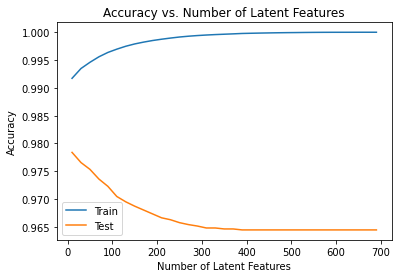

In [47]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

num_latent_feats = np.arange(10,700,20)
train_accuracy = []
test_accuracy = []

for k in num_latent_feats:
    s_k, u_train, vt_train = np.diag(s[:k]), u[:, :k], vt[:k, :]

    u_test = u_train[user_item_train.index.isin(user_item_test.index), :]
    vt_test = vt_train[:, user_item_train.columns.isin(user_item_test.columns)]


    user_item_train_preds = fit_transform(s_k, u_train, vt_train)
    user_item_test_preds = fit_transform(s_k, u_test, vt_test)

    train_accuracy.append(calculate_accuracy(user_item_train, user_item_train_preds))
    test_accuracy.append(calculate_accuracy(user_item_test_sub, user_item_test_preds))

print(train_accuracy)
plot_accuracy(num_latent_feats, train_accuracy, "Train")

print(test_accuracy)
plot_accuracy(num_latent_feats, test_accuracy, "Test")

### `6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

> **The Number of Latent Features**

> Such a waste of data that only 20 users are  

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

In [48]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

4294967295